# Classifying CIFAR 100 with a pretrained model

In [1]:
import tensorflow as tf

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="coarse")

# Print the shape of the data
print(f'Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}')
print(f'Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}')
num_classes = len(set(y_train.flatten()))
print(f'Number of different labels: {num_classes}')

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training data shape: (50000, 32, 32, 3), Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000, 1)
Number of different labels: 20


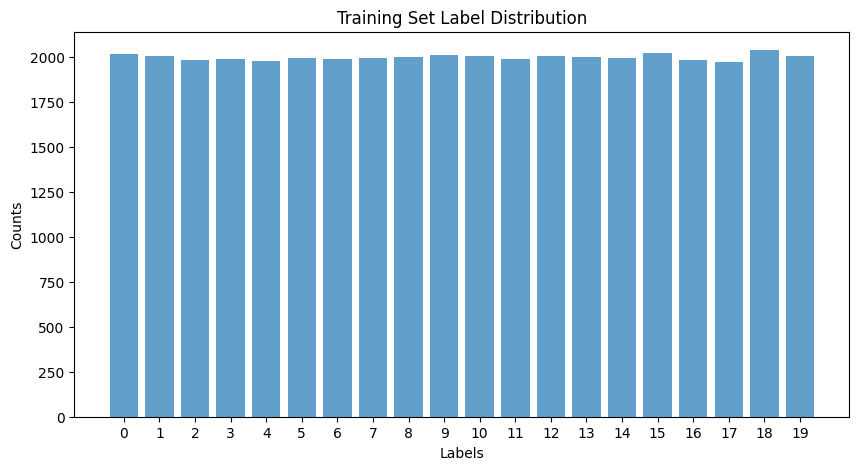

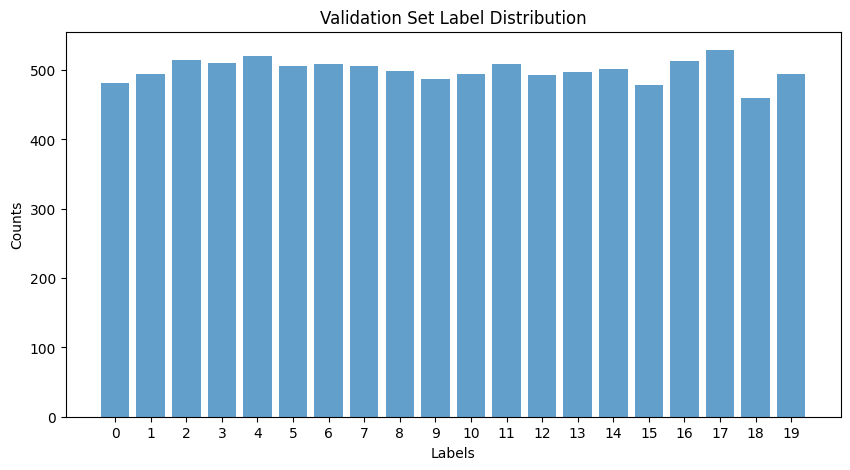

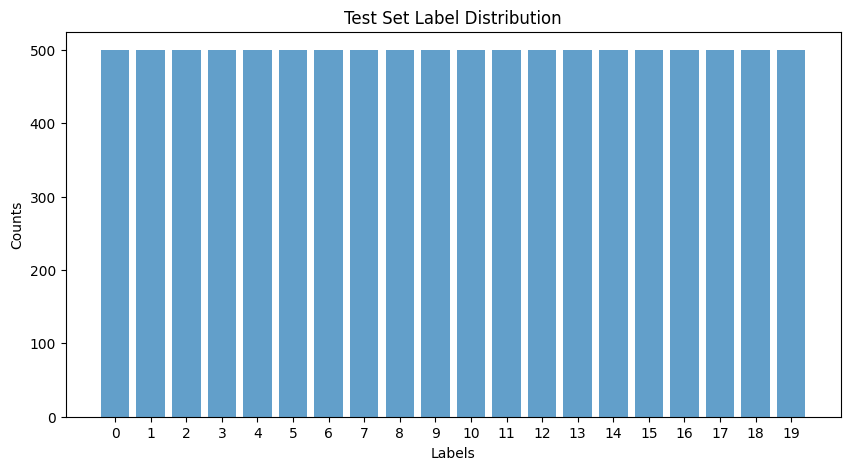

New training data shape: (40000, 32, 32, 3), New training labels shape: (40000, 1)
Validation data shape: (10000, 32, 32, 3), Validation labels shape: (10000, 1)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000, 1)


In [3]:
from utils import plot_label_distribution
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

import matplotlib.pyplot as plt


plot_label_distribution(y_train, 'Training Set Label Distribution')
plot_label_distribution(y_val, 'Validation Set Label Distribution')
plot_label_distribution(y_test, 'Test Set Label Distribution')

print(f'New training data shape: {x_train.shape}, New training labels shape: {y_train.shape}')
print(f'Validation data shape: {x_val.shape}, Validation labels shape: {y_val.shape}')
print(f'Test data shape: {x_val.shape}, Test labels shape: {y_val.shape}')


In [5]:
train_dataset = (x_train, y_train)
val_dataset = (x_val, y_val)
test_dataset = (x_test, y_test)

In [4]:
import tensorflow as tf

BATCH_SIZE = 128
IMG_SIZE = (224, 224)

def resize_only(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, IMG_SIZE)
    return image, label

# Pipeline para el conjunto de entrenamiento (sin cache)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(resize_only, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Pipeline para validación
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(resize_only, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Pipeline para test
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(resize_only, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


## Try a pair of models using feature extraction

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
import keras
conv_base_resnet = keras.applications.ResNet50V2(include_top = False,
                                        weights = 'imagenet',
                                        input_shape= (224,224,3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
conv_base_resnet.trainable = False

In [18]:
conv_base_resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x  = keras.applications.resnet_v2.preprocess_input(x)
x = conv_base_resnet(x)
x = layers.Flatten()(x)
x= layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Dropout para combatir el overfitting
outputs = layers.Dense(20, activation='softmax')(x)
model_resnet_fe = keras.Model(inputs, outputs)
model_resnet_fe.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/resnet_fe.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True)
]
history = model_resnet_fe.fit(
    train_ds,
    epochs=200,
    validation_data=val_ds,
    callbacks=callbacks,
    batch_size=128)

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 198s 606ms/step - accuracy: 0.5256 - loss: 1.7427 - val_accuracy: 0.7479 - val_loss: 0.7997
Epoch 2/200
 18/313 ━━━━━━━━━━━━━━━━━━━━ 2:10 444ms/step - accuracy: 0.6642 - loss: 1.0760

KeyboardInterrupt: 

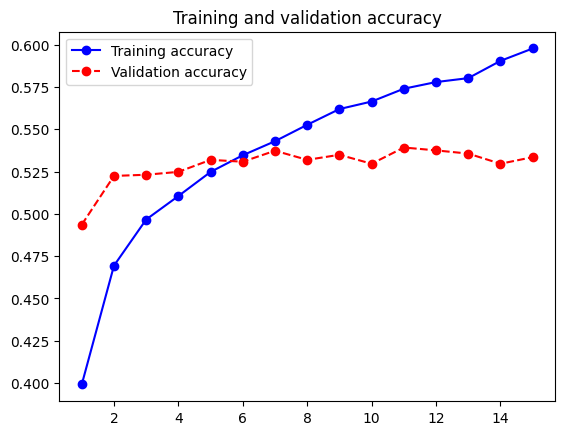

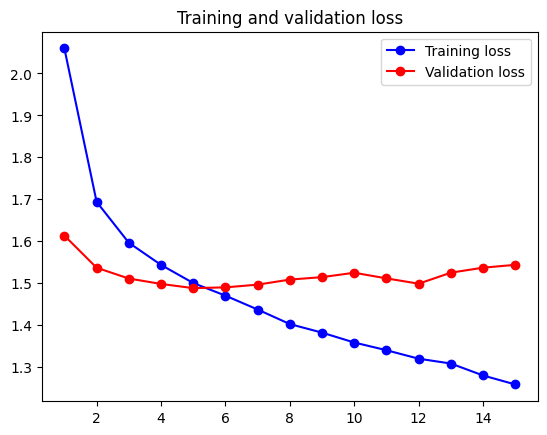

In [ ]:
from utils import plot

plot(history)

79/79 - 31s - 397ms/step - accuracy: 0.7424 - loss: 0.8292
Test accuracy: 74.24%
Test loss: 0.8292
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 423ms/step


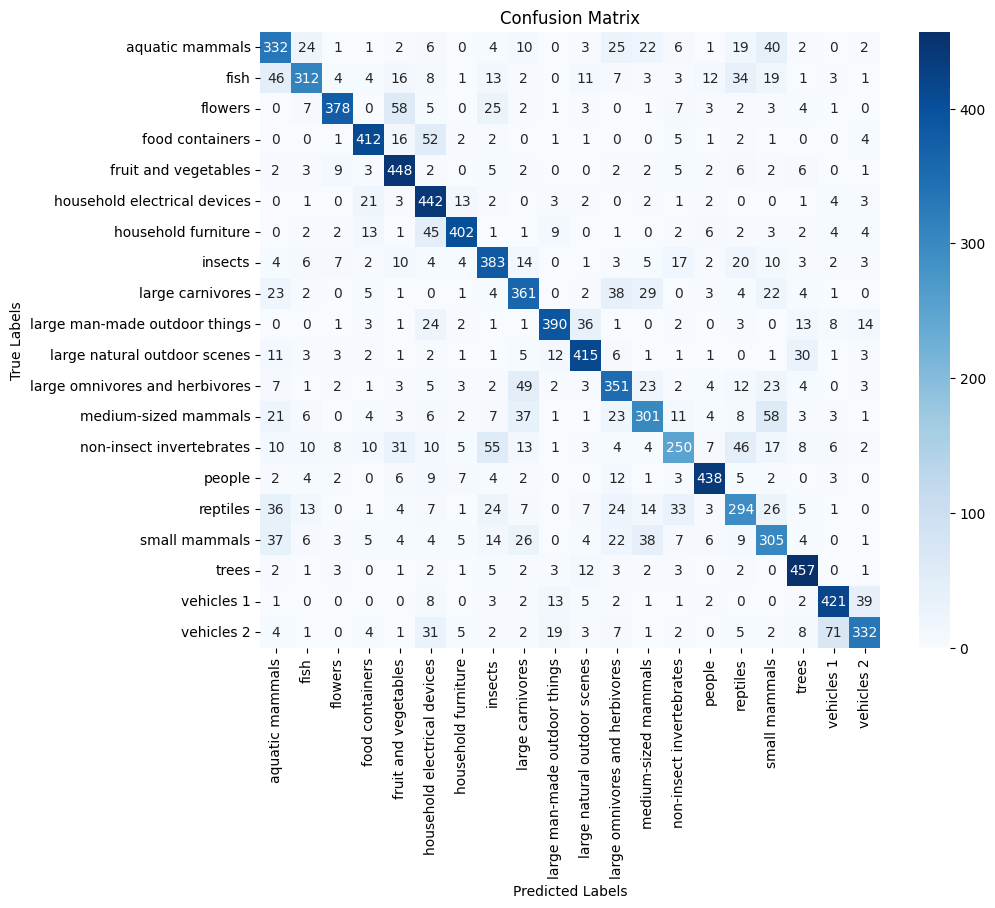

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model_resnet_fe.evaluate(test_ds, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Predict the classes for the test set
y_pred = model_resnet_fe.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Extraer las etiquetas verdaderas del dataset test
# Se recorre el dataset y se concatenan las etiquetas en un array de numpy
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = y_true.flatten()  # Asegurarse de que tenga forma (num_samples,)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)


# Define the category names
category_names = [
    "aquatic mammals",
    "fish",
    "flowers",
    "food containers",
    "fruit and vegetables",
    "household electrical devices",
    "household furniture",
    "insects",
    "large carnivores",
    "large man-made outdoor things",
    "large natural outdoor scenes",
    "large omnivores and herbivores",
    "medium-sized mammals",
    "non-insect invertebrates",
    "people",
    "reptiles",
    "small mammals",
    "trees",
    "vehicles 1",
    "vehicles 2"
]

# Plot the confusion matrix with category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [17]:
conv_base_efficient = keras.applications.EfficientNetB5(include_top = False,
                                        weights = 'imagenet',
                                        input_shape= (224,224,3))
conv_base_efficient.trainable = False
conv_base_efficient.summary()


115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "efficientnetb5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 28,513,527 (108.77 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 28,513,527 (108.77 MB)

In [18]:
from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x) # pass throught function
x = conv_base_efficient(x)
x = layers.Flatten()(x)
x= layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Dropout para combatir el overfitting
outputs = layers.Dense(20, activation="softmax")(x)
model_efficient_fe = keras.Model(inputs, outputs)
model_efficient_fe.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/efficientnet_fe.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True)
]
history = model_efficient_fe.fit(
    train_ds,
    epochs=200,
    validation_data=(val_ds),
    callbacks=callbacks,
    batch_size=128)

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.5713 - loss: 1.4749 - val_accuracy: 0.8151 - val_loss: 0.6031
Epoch 2/200


KeyboardInterrupt: 

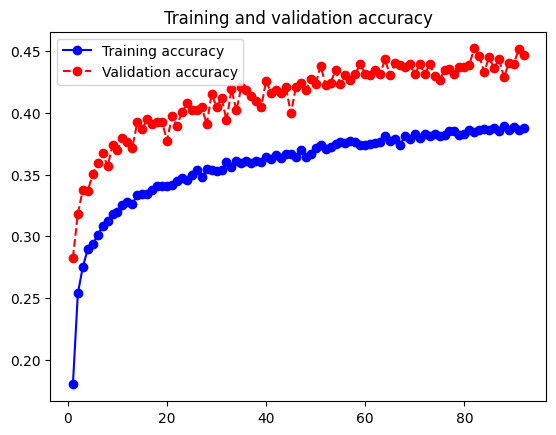

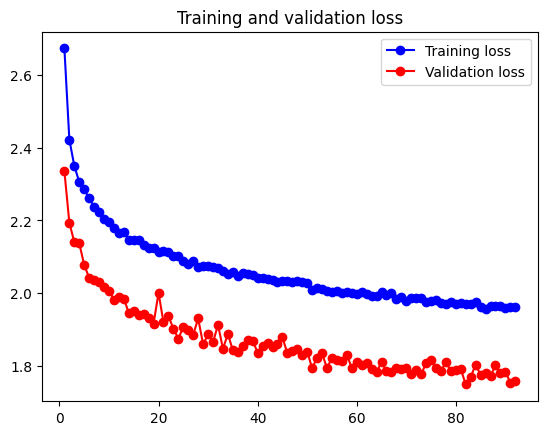

In [ ]:
plot(history)

79/79 - 74s - 931ms/step - accuracy: 0.8073 - loss: 0.6220
Test accuracy: 80.73%
Test loss: 0.6220
79/79 ━━━━━━━━━━━━━━━━━━━━ 84s 998ms/step


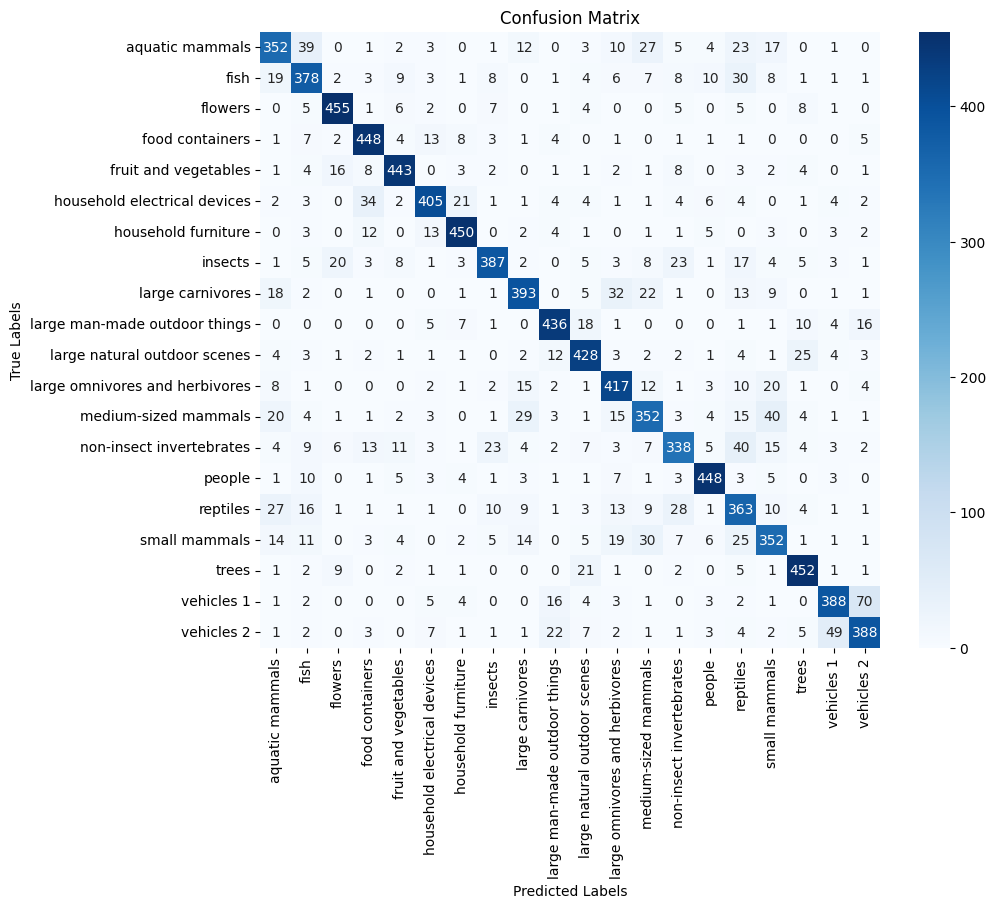

In [21]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_efficient_fe.evaluate(test_ds, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Predict the classes for the test set
y_pred = model_efficient_fe.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Extraer las etiquetas verdaderas del dataset test
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = y_true.flatten()

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix with category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Train the same models but using fine tuning

In [22]:
conv_base_resnet = keras.applications.ResNet50V2(include_top = False,
                                        weights = 'imagenet',
                                        input_shape= (224,224,3))

conv_base_resnet.trainable = True

for layer in conv_base_resnet.layers[:-27]:
    layer.trainable = False

conv_base_resnet.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 12,083,200 (46.09 MB)

 Non-trainable params: 11,481,600 (43.80 MB)

In [25]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x  = keras.applications.resnet_v2.preprocess_input(x)
x = conv_base_resnet(x)
x = layers.Flatten()(x)
x= layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Dropout para combatir el overfitting
outputs = layers.Dense(20, activation='softmax')(x)
model_resnet_ft = keras.Model(inputs, outputs)
model_resnet_ft.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/resnet_ft.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True)
]
history = model_resnet_ft.fit(
    train_ds,
    epochs=200,
    validation_data=(val_ds),
    callbacks=callbacks,
    batch_size=128)

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 259s 792ms/step - accuracy: 0.5624 - loss: 1.4448 - val_accuracy: 0.7662 - val_loss: 0.7393
Epoch 2/200
 50/313 ━━━━━━━━━━━━━━━━━━━━ 2:34 588ms/step - accuracy: 0.7310 - loss: 0.8280

KeyboardInterrupt: 

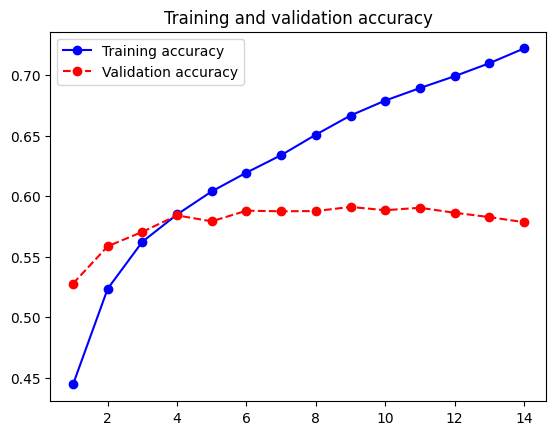

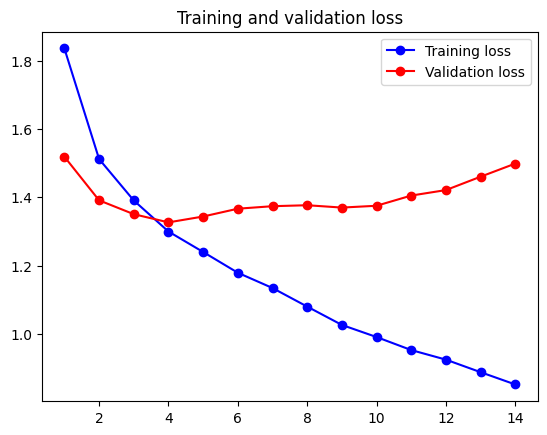

In [ ]:
plot(history)

79/79 - 30s - 384ms/step - accuracy: 0.7669 - loss: 0.7373
Test accuracy: 76.69%
Test loss: 0.7373
79/79 ━━━━━━━━━━━━━━━━━━━━ 74s 936ms/step


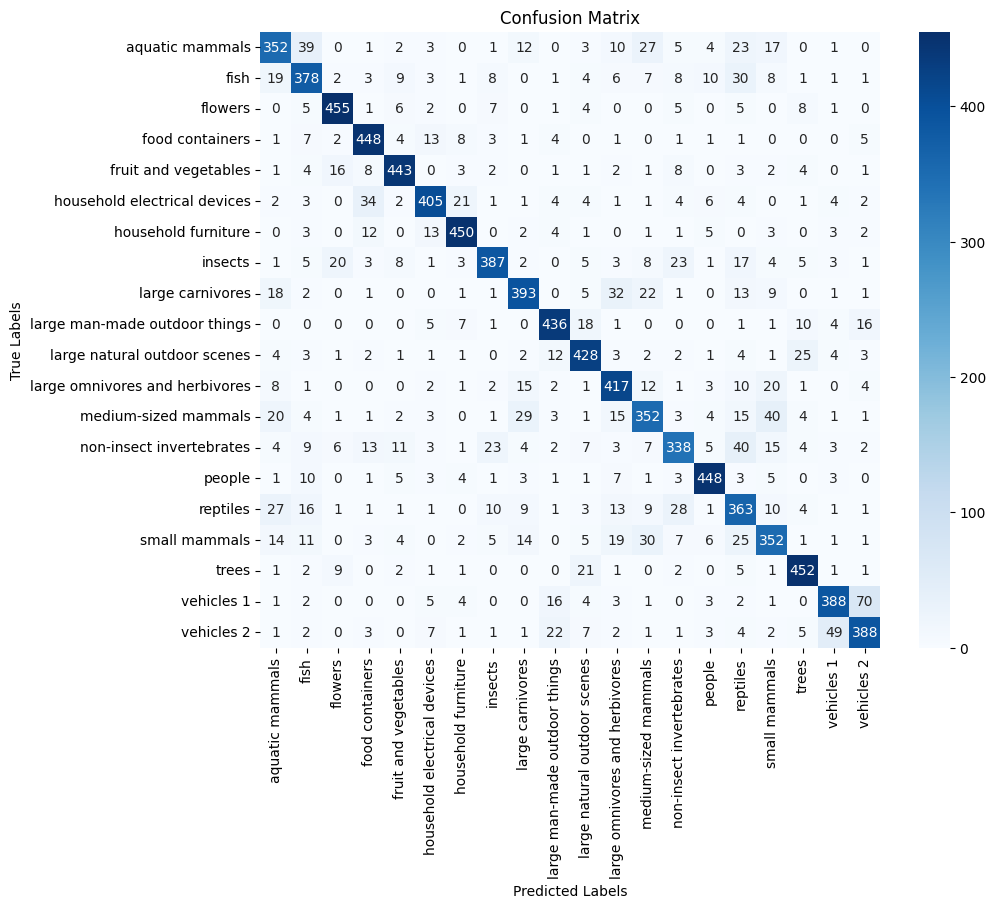

In [26]:

# Evaluate the model on the test set
test_loss, test_accuracy = model_resnet_ft.evaluate(test_ds, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Realizar las predicciones sobre el conjunto de test
y_pred = model_efficient_fe.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Extraer las etiquetas verdaderas del dataset test
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = y_true.flatten()

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix with category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
conv_base_efficient = keras.applications.EfficientNetB3(include_top = False,
                                        weights = 'imagenet',
                                        input_shape= (224,224,3))
conv_base_efficient.trainable = True

for layer in conv_base_efficient.layers[:-25]:
    layer.trainable = False

conv_base_efficient.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 3,536,074 (13.49 MB)

 Non-trainable params: 7,247,461 (27.65 MB)

In [28]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = conv_base_efficient(x)
x = layers.Flatten()(x)
x= layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(20, activation='softmax')(x)
model_efficient_ft = keras.Model(inputs, outputs)
model_efficient_ft.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/efficient_ft.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True)
]
history = model_efficient_ft.fit(
    train_ds,
    epochs=200,
    validation_data=(val_ds),
    callbacks=callbacks,
    batch_size=128)

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 314s 783ms/step - accuracy: 0.6331 - loss: 1.2227 - val_accuracy: 0.8285 - val_loss: 0.5419
Epoch 2/200
 28/313 ━━━━━━━━━━━━━━━━━━━━ 2:50 599ms/step - accuracy: 0.7917 - loss: 0.6507

KeyboardInterrupt: 

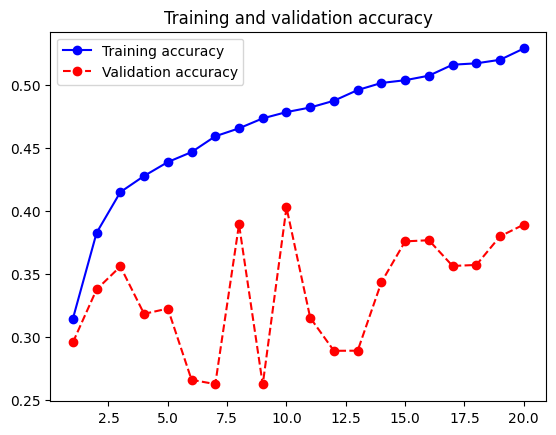

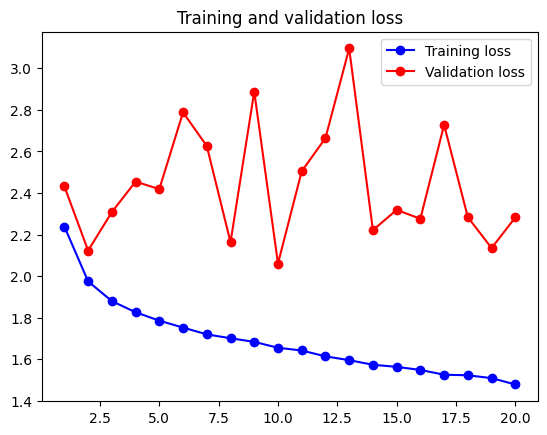

In [ ]:
plot(history)

79/79 - 40s - 504ms/step - accuracy: 0.8258 - loss: 0.5541
Test accuracy: 82.58%
Test loss: 0.5541
79/79 ━━━━━━━━━━━━━━━━━━━━ 73s 921ms/step


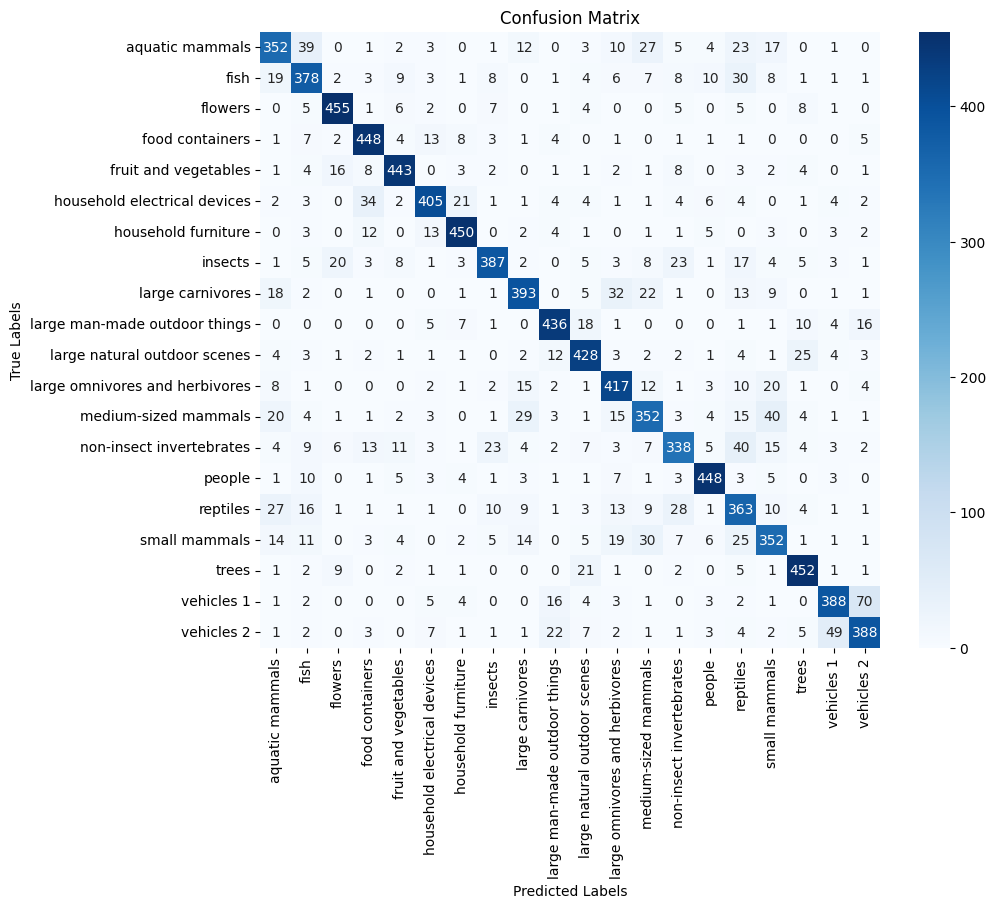

In [29]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model_efficient_ft.evaluate(test_ds, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Realizar las predicciones sobre el conjunto de test
y_pred = model_efficient_fe.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Extraer las etiquetas verdaderas del dataset test
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = y_true.flatten()

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix with category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()